## Stigulsútreikningar í þjálfun tauganeta

Eftirfarandi dæmi sýnir stigulsútreikninga fyrir einfalt tauganet og minnstu kvaðrata markfall. Tauganetið hefur tvær inntaksnóður og eina úttaksnóðu (engar huldar nóður). Ennfremur er sýnt hvernig hægt er að sannreyna stigulsútreikninga með því að nálga stigulinn tölulega með svokallaðri mismunaaðferð (e. finite difference method). Í henni er afleiða falls $f$ af einni breytistærð, $w \in \mathbb{R}$ nálguð með
$$
f'(w) \approx \frac{f(w+h)-f(w-h)}{2h}
$$
þar sem $h>0$ er einhver lítil tala. Á hliðstæðan hátt fást hlutafleiður fyrir föll af mörgum breytistærðum, $w \in \mathbb{R}^q$,
$$
\frac{\partial f}{\partial w_j} = \approx \frac{f(x+he_j)-f(x-he_j)}{2h}
$$
þar sem $e_j$ er einingavigur samsíða $j$-ta ás hnitakerfisins (stak $j$ er 1, öll önnur stök eru 0). Athugið að það þarf að reikna $2q$ fallsgildi til að nálga stigulinn í einum punkti. Backpropagation aðferðin er talsvert hagkvæmari og er þess vegna mikið notuð við þjálfun tauganeta.

Flestum for-lykkjum í kóðanum er hægt að skipta út fyrir vektoraðgerðir til að flýta útreikningum. Ennfremur er verið að reikna sömu stærðirnar óþarflega oft.

Nánar: http://cs231n.github.io/neural-networks-3/#gradcheck

In [1]:
import numpy as np

def g(z):
    # Activation function (sigmoid)
    return 1/(1+np.exp(-z))

def dg(z):
    # Derivative of the sigmoid activation function
    return g(z)*(1-g(z))

def J(w,X,y):
    # Least squares objective function
    s=0
    for i in range(X.shape[0]):
        s+=(y[i]-g(np.dot(w.T,X[i,:])))**2
    return s

def gradJ(w,X,y):
    # Exact gradient
    n,p = X.shape
    grad=np.zeros(p)
    for i in range(n):
        for j in range(p):
            grad[j]+=2*(y[i]-g(np.dot(w.T,X[i,:])))*(-dg(np.dot(w.T,X[i,:])))*X[i,j] # Not optimized at all!
    return grad

def approx_grad(w,X,y,h=1e-4):
    # Finite difference approximation of the gradient of f (central differences)
    # Note: If h becomes very small, round-off errors will dominate
    p=len(w)
    grad=np.zeros(p)
    for j in range(p):
        e = np.zeros((p,1))
        e[j] = 1
        grad[j]=(J(w + e*h, X,y) - J(w - e*h, X,y))/(2*h)
    return grad

# Toy data set
X=np.array([[1,2],[2,5]])
y=np.array([0,1])
w=np.array([-3.1,-0.23]).reshape(2,1) # Fix weights to some arbitrary values

print("Exact gradient: ", gradJ(w, X,y))
print("Approximate gradient:", approx_grad(w,X,y,1e-4))

Exact gradient:  [-0.0010784 -0.0034395]
Approximate gradient: [-0.0010784 -0.0034395]


Eftirfarandi dæmi sýnir hvernig hægt er að þjálfa einfalt tauganet með aðferð mesta bratta þar sem mismunaaðferðin er notuð til að nálga stigulinn. Netið hefur 2 inntaksnóður, eitt hulið lag með 3 nóðum og eina úttaksnóðu. Markfallið er minnsta kvaðratskekkja.

Athugið að útreikningar hafa ekki verið "optimeraðir" með tilliti til hraða. Backpropagation myndi svo gefa mikinn tímasparnað.

In [3]:
# NN training using gradient descent and numerical approximation of the gradient

import numpy as np

# Model parameters W1, W2, b1, b2 are stacked in vector w
# NB Hard coding of matrix/vector dimensions is an ugly hack!
def pack_vector(W1,W2,b1,b2):
    return np.vstack((W1.reshape(6,1), W2.reshape(3,1), b1, b2))

def unpack_vector(w):
    W1=w[0:6].reshape(3,2)
    W2=w[6:9].reshape(1,3)
    b1=w[9]
    b2=w[10]
    return W1, W2, b1, b2
    
def g(z):
    return 1/(1+np.exp(-z)) # Sigmoid activation function

def predict(w,x):
    W1,W2,b1,b2=unpack_vector(w)
    # Feedforward operation
    z1=np.dot(W1,x.reshape(2,1)) + b1
    a1=g(z1) # Layer 1 activation
    z2=np.dot(W2,a1) + b2
    a2=g(z2) # Layer 2 activation
    return a2

def J(w,X,y):
    # Least squares objective function
    s=0
    for i in range(X.shape[0]):
        s +=(y[i]-predict(w,X[i,:]))**2
    return s

def approx_grad(f,w,X,y,h=1e-4):
    p=len(w)
    grad=np.zeros((p,1))
    for j in range(p):
        e = np.zeros((p,1))
        e[j] = 1
        grad[j]=(f(w + e*h, X,y) - f(w - e*h, X,y))/(2*h)
    return grad

# 2D data set from homework 3
data=np.genfromtxt('hw3_data_a.txt')
X=data[:,1:]
y=data[:,0]
y[y==-1]=0

# NN architeture: 2 inputs, 3 hidden nodes, 1 output
# Initialization
sigma=0.1
W1=sigma*np.random.randn(3,2)
W2=sigma*np.random.randn(1,3)
b1=sigma*np.random.randn(1)
b2=sigma*np.random.randn(1)

# Batch gradient descent
alpha=0.1
w=pack_vector(W1,W2,b1,b2) # Model parameters
for k in range(1,1001):
    if np.mod(k,100) == 0:
        print("Iter:", k, "obj=", J(w,X,y))
    dJ=approx_grad(J,w,X,y,1e-4)
    w = w - alpha*dJ
print("Final weights")
print(w)

Iter: 100 obj= [[13.92516262]]
Iter: 200 obj= [[7.965364]]
Iter: 300 obj= [[6.57457901]]
Iter: 400 obj= [[6.02760413]]
Iter: 500 obj= [[5.75441038]]
Iter: 600 obj= [[5.59900434]]
Iter: 700 obj= [[5.50280902]]
Iter: 800 obj= [[5.43969703]]
Iter: 900 obj= [[5.39650416]]
Iter: 1000 obj= [[5.36594363]]
Final weights
[[-7.62142072]
 [-6.8632327 ]
 [-7.77224108]
 [-7.12437522]
 [-0.21252371]
 [-1.80511583]
 [-5.78731141]
 [-6.11806529]
 [ 4.69742698]
 [ 6.58408172]
 [-0.5293651 ]]


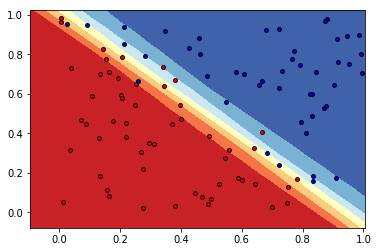

In [5]:
# Draw the decusion boundary 
import matplotlib.pyplot as plt
plot_colors = 'rby'
plot_step = 0.1 # Grid density
n_classes= len(np.unique(y))
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
Xgrid=np.c_[xx.ravel(), yy.ravel()]
Z=np.zeros(Xgrid.shape[0])
for i in range(Xgrid.shape[0]):
    Z[i]=predict(w,Xgrid[i])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
plt.show()